# Content Outline

Grüezi mitenand! ☕

In this notebook we will look at how to implement an LSTM for NER. We will use a package called Keras, where the LSTM is already packaged in a layer. 

If you'd like to implement an LSTM from scratch, you can do that in tensorflow or PyTorch and you can find extra reading about that in the Take Home exercises section.

We will:
1.   Load the same NER dataset from [Huggingface datasets](https://huggingface.co/docs/datasets/)
2.   Data Preprocessing
3.   Training an LSTM model using Keras
4.   Evaluation


For this session we will also activate the GPU settings in Colab. To activate the GPU please go to:


```
Runtime -> Change runtime type -> Hardware Accelerator -> GPU
```

To check that the GPU is enabled, run the following command:



In [ ]:
!nvidia-smi

Mon Jan 17 09:58:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

You can also check via tensorflow. If the GPU is enabled the below command will give the following output:

```
/device:GPU:0
```



In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Comment out the below lines to install the packages that we will need. 

## Data
!pip install datasets
!pip install pandarallel
!pip install pandarallel

# Evaluation
!pip install sklearn_crfsuite
!pip install seqeval

     |████████████████████████████████| 306 kB 4.2 MB/s 
     |████████████████████████████████| 133 kB 70.3 MB/s 
     |████████████████████████████████| 67 kB 6.3 MB/s 
     |████████████████████████████████| 243 kB 73.3 MB/s 
     |████████████████████████████████| 1.1 MB 68.2 MB/s 
     |████████████████████████████████| 160 kB 63.4 MB/s 
     |████████████████████████████████| 271 kB 76.0 MB/s 
     |████████████████████████████████| 192 kB 77.8 MB/s 
  Created wheel for pandarallel: filename=pandarallel-1.5.4-py3-none-any.whl size=18690 sha256=93aa9ca292c20dff455dfc398d1b1a79faff3925bbeb392142848edbad3255b7
  Stored in directory: /root/.cache/pip/wheels/71/de/ad/759faf4fea1e9b0fd935da28847aa3ca2eef14a888c2dc4952
Successfully built pandarallel
     |████████████████████████████████| 743 kB 4.2 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=4366196fc02ad1d7e66f504c1ec186904eb461df5

In [ ]:
# Imports

# Standard
from typing import List, Dict

# Data & Data Preprocessing
from datasets import load_dataset, get_dataset_split_names
import itertools
import numpy as np
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# Model
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

# Evaluation
from sklearn import metrics
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from seqeval.scheme import IOB2

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# NER

## Loading the Data
Same as in the previous notebook we will use the conllpp++ dataset for Named Entity Recognition (NER). However, this time we want to load all data splits: **train**, **validation** and **test**.

In [ ]:
# You can read more about it here: https://huggingface.co/datasets/conllpp
# You can also get all splits: e.g., load_dataset('conllpp'). 

train = pd.DataFrame(load_dataset('conllpp', split = 'train'))
valid = pd.DataFrame(load_dataset('conllpp', split = 'validation'))
test = pd.DataFrame(load_dataset('conllpp', split = 'test'))

Downloading:   0%|          | 0.00/2.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/650k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/141k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset conllpp downloaded and prepared to /root/.cache/huggingface/datasets/conllpp/conllpp/1.0.0/04f15f257dff3fe0fb36e049b73d51ecdf382698682f5e590b7fb13898206ba2. Subsequent calls will reuse this data.


In [ ]:
f'The train split is with size {train.shape}, the validation split is {valid.shape} and the test split is with size {test.shape}.'

'The train split is with size (14041, 5), the validation split is (3250, 5) and the test split is with size (3453, 5).'

In [ ]:
# Hyperparameter tuning -- LSTM, cross-validation splits.

## Data Preprocessing
Before we start training our model, we have to make sure that the data is in format that the model can "recognize". This means that we need to encode our data and pass it through an embeddings layer.

### Label with the IOB scheme

In [ ]:
train.head()

,id,tokens,pos_tags,chunk_tags,ner_tags
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]"
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]"
3,3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


In [ ]:
ner_tags_map = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

In [ ]:
def reverse_map(dictionary: Dict)->Dict:
  
  return {v:k for k,v in dictionary.items()}

In [ ]:
def ner_tags_to_gold_standard(ner_tags: List[int], ner_tags_map=ner_tags_map)->List[str]:
  '''
  Args:
      ner_tags: A list with the size of the tokens list labelled 1-8, where 
      each number means a different entity, and whetehr it is the beginning or 
      end of it.

      ner_tags_map: A mapping between IOB and the numbers defined in the
      dataset description.

  Returns:
      A list of the original tokens mapped to the IOB scheme without the 
      MISC entity.
    
  Example Usage:
    ner_tags_to_gold_standard(
      [7, 0, 0, 0, 1, 2, 2, 0, 0, 0, 3, 4], 
      {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8})

    return: ['O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'B-ORG', 'I-ORG']
  '''

  reversed_ner_tags_map = reverse_map(ner_tags_map)
  
  result = []
  for element in ner_tags:
    if (element == 7) or (element == 8):
      result.append('O')
    else:
      result.append(reversed_ner_tags_map.get(element))

  return result

Add the gold_standard column, where the labels of the data follow the IOB scheme.

In [ ]:
train['gold_standard'] = train.ner_tags.apply(ner_tags_to_gold_standard)
train.head()

,id,tokens,pos_tags,chunk_tags,ner_tags,gold_standard
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]","[B-ORG, O, O, O, O, O, O, O, O]"
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]","[B-PER, I-PER]"
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]","[B-LOC, O]"
3,3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...","[O, B-ORG, I-ORG, O, O, O, O, O, O, O, O, O, O..."
4,4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...","[B-LOC, O, O, O, O, B-ORG, I-ORG, O, O, O, B-P..."


In [ ]:
# Do the same for the validation and test datasets.
valid['gold_standard'] = valid.ner_tags.apply(ner_tags_to_gold_standard)
test['gold_standard'] = test.ner_tags.apply(ner_tags_to_gold_standard)

### Analyze the input (source) text
First, let's look at how long are the majority of the sentences in the datatset.

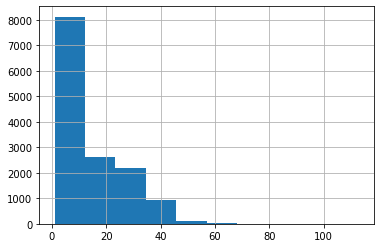

In [ ]:
train.tokens.apply(len).hist()

From the histogram above we see that actually most of the sentences are pretty short. Next, let's transform the data to a token by token basis.

In [ ]:
def transform_dataset(df):

  return pd.DataFrame(data={
      'sentence #': list(itertools.chain(*[[int(row.id)]*len(row.tokens) for i, row in df.iterrows()])),
      'token': list(itertools.chain(*df.tokens.values)),
      'true': list(itertools.chain(*df.gold_standard.values))
  })

transform_dataset(train).head(10)

,sentence #,token,true
0,0,EU,B-ORG
1,0,rejects,O
2,0,German,O
3,0,call,O
4,0,to,O
5,0,boycott,O
6,0,British,O
7,0,lamb,O
8,0,.,O
9,1,Peter,B-PER


In [ ]:
train_df = transform_dataset(train)
valid_df = transform_dataset(valid)
test_df = transform_dataset(test)

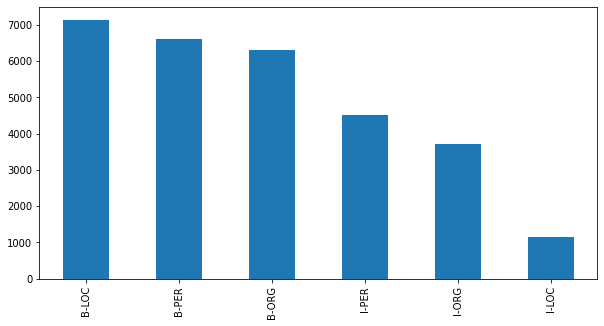

In [ ]:
# Below we can see what is the distribution of labels in the dataset.

train_df[train_df.true != 'O'].true.value_counts().plot(kind="bar", figsize=(10,5))

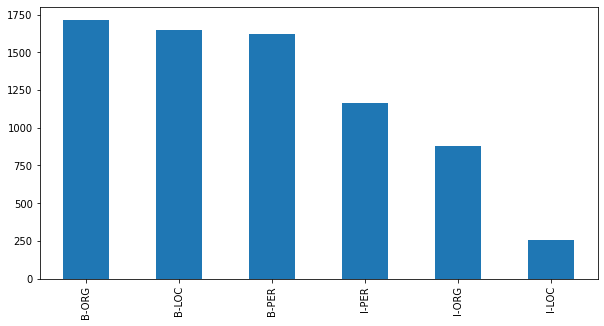

In [ ]:
test_df[test_df.true != 'O'].true.value_counts().plot(kind="bar", figsize=(10,5))

### Building the dictionary/vocabulary

There are multiple ways to build a dictionary, one is to build it yourselves. For example we can build a dictionary `word2index` that assigns a unique integer value to every unique word from the corpus. We also construct a reversed dictionary that maps indices to words `index2word` to be able to map them back when the model is trained and we want it to predict.

In [ ]:
df = pd.concat([train_df, valid_df, test_df])
assert df.shape[0] == train_df.shape[0] + valid_df.shape[0] + test_df.shape[0]

all_words = list(set(df.token.values))
word2index = {word: idx + 2 for idx, word in enumerate(all_words)} # example: {'Giovanna': 945, '746,000': 946, 'OPEN': 947, 'delegations': 948,}

word2index['UNKNOWN_WORD']=0
word2index['PADDING']=1

index2word = {idx: word for word, idx in word2index.items()}

In [ ]:
print(f'Vocab size of Custom index map is {len(all_words)}')

Vocab size of Custom index map is 30289


In [ ]:
tokeniser = tf.keras.preprocessing.text.Tokenizer(lower=False, filters='')
tokeniser.fit_on_texts([' '.join(row.tokens) for i, row in train.iterrows()])

In [ ]:
print(f'Vocab size of Tokeniser {len(tokeniser.word_index) + 1}') # Index 0 is reserved for padding, therefore we add 1 to the overall length..

Vocab size of Tokeniser 23624


In [ ]:
tokeniser.index_word[128]

'played'

### Hands-On Exercise 1 (5 min)
Have a closer look at how the words in your dictionary look like. As we see from above according to the methodology we use, we can have varying dictionary sizes. If we needed to, how else would you reduce the size of your dictionary?


In [ ]:
# Place your code here.

### Building the labels dictionary

Let's also build a similar dictionaty also for out true labels.


In [ ]:
all_tags = list(set(df.true.values))

tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index['PADDING'] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

In [ ]:
# Just an example to see what we did.
label = 'B-PER'
indx = 1

print(f'The index of the label {label} is {tag2index.get(label)}.')
print(f'The label with index {indx} is {index2tag.get(indx)}.')

The index of the label B-PER is 4.
The label with index 1 is B-LOC.


### Padding the sequence (input)
We will be following [this](https://www.kaggle.com/aiswaryaramachandran/ner-using-lstm-s-and-keras) tutorial. More information on tensorflow operations can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical).

In [ ]:
# The LSTM takes sentences of the same input size, therefore we have to pad the ones that are shorter. 
# To know how much we have to pad them, we need to find the longest sentence.

max_sentence_length=max([len(row.tokens) for i, row in train.iterrows()])
print(f'The longest sentence has {max_sentence_length} words/tokens.')

The longest sentence has 113 words/tokens.


In [ ]:
# Encode the sentences using the Tokeniser from tensorflow.
sentences_train = [' '.join(row.tokens) for i, row in train.iterrows()]
encoded_sentences_train = tokeniser.texts_to_sequences([' '.join(row.tokens) for i, row in train.iterrows()])

print(f'The first original sentence is: {sentences_train[0]}')
print(f'The equivalent encoded sentence is: {encoded_sentences_train[0]}')
print(f'The lengths of the original and encoded sentences {dict(true="ARE", false="are NOT")[str(len(sentences_train[0].split())==len(encoded_sentences_train[0])).lower()]} equal.')
print(f'Length of the first sentence: {len(encoded_sentences_train[0])}')

The first original sentence is: EU rejects German call to boycott British lamb .
The equivalent encoded sentence is: [957, 11983, 233, 762, 6, 4147, 209, 6182, 1]
The lengths of the original and encoded sentences ARE equal.
Length of the first sentence: 9


In [ ]:
# Encode the gold_standard labels/tags to indexes.
encoded_tags_train=[[tag2index[w] for w in row.gold_standard] for i, row in train.iterrows()]

print(f'The first original sentence is: {sentences_train[0]}')
print(f'The labels of the first original sentence are: {train.iloc[0].gold_standard} ')
print("First Sentence Encoded Tags ", encoded_tags_train[0])
print("Is length of Original Tags and Encoded Tags same ",len(train.iloc[0].gold_standard)==len(encoded_tags_train[0]))
print("Length of Tags for First Sentence ",len(encoded_tags_train[0]))

The first original sentence is: EU rejects German call to boycott British lamb .
The labels of the first original sentence are: ['B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] 
First Sentence Encoded Tags  [7, 6, 6, 6, 6, 6, 6, 6, 6]
Is length of Original Tags and Encoded Tags same  True
Length of Tags for First Sentence  9


In [ ]:
max_len=128 # The nearest power of 2 to 113.
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

padded_encoded_sentences_train=pad_sequences(maxlen=max_len,sequences=encoded_sentences_train,padding="post",value=0)
padded_encoded_tags_train=pad_sequences(maxlen=max_len,sequences=encoded_tags_train,padding="post",value=tag2index['O'])

print("Shape of Encoded Sentence ",padded_encoded_sentences_train.shape)
print("Shape of Encoded Labels ",padded_encoded_tags_train.shape)

print("First Encoded Sentence Without Padding ", encoded_sentences_train[0])
print("First Encoded Sentence with padding ",padded_encoded_sentences_train[0])
print("First Sentence Encoded Label without Padding ",encoded_tags_train[0])
print("First Sentence Encoded Label with Padding ",padded_encoded_tags_train[0])
print(type(padded_encoded_tags_train[0]))

Shape of Encoded Sentence  (14041, 128)
Shape of Encoded Labels  (14041, 128)
First Encoded Sentence Without Padding  [957, 11983, 233, 762, 6, 4147, 209, 6182, 1]
First Encoded Sentence with padding  [  957 11983   233   762     6  4147   209  6182     1     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
First Sentence Enco

In [ ]:
target = [to_categorical(element.tolist()) for element in padded_encoded_tags_train]
print(f'The shape of labels  after converting to categorical for the first sentence is {target[0].shape}.')

The shape of labels  after converting to categorical for the first sentence is (128, 8).


## Get the Train and Valid data

In [ ]:
def get_max_len(df):
  powers_of_2 = [2**i for i in range(8)]
  max_sentence_len = max([len(row.tokens) for i, row in df.iterrows()])
  concatenated = sorted(powers_of_2 + [max_sentence_len])

  return concatenated[concatenated.index(max_sentence_len) + 1]

def get_encoded_sentences(df):
  sentences = [' '.join(row.tokens) for i, row in df.iterrows()]
  return tokeniser.texts_to_sequences([' '.join(row.tokens) for i, row in df.iterrows()])

def get_encoded_tags(df, tag2index):
  return [[tag2index[w] for w in row.gold_standard] for i, row in df.iterrows()]

def get_padded_encoded_sentences(encoded_sentences, max_len):
  return pad_sequences(maxlen=max_len,sequences=encoded_sentences,padding="post",value=0)

def get_target(encoded_tags, tag2index, max_len):
  padded_encoded_tags = pad_sequences(maxlen=max_len,sequences=encoded_tags,padding="post",value=tag2index['O'])

  return [to_categorical(element.tolist(), num_classes=8) for element in padded_encoded_tags]


def get_preprocessed_dataset(df, tag2index):

  return get_padded_encoded_sentences(get_encoded_sentences(df), get_max_len(df)), get_target(get_encoded_tags(df, tag2index), tag2index, get_max_len(df))

padded_encoded_sentences_valid, target_valid = get_preprocessed_dataset(valid, tag2index)
padded_encoded_sentences_train, target_train = get_preprocessed_dataset(train, tag2index)
padded_encoded_sentences_test, target_test = get_preprocessed_dataset(test, tag2index)

In [ ]:
padded_encoded_sentences_valid[0].shape

(128,)

In [ ]:
target_valid[0].shape

(128, 8)

## Building the Model

In [ ]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

In [ ]:
embedding_dim=128
vocab_size=len(tokeniser.word_index) + 1
lstm_units=128
max_len=128

input_word = Input(shape = (max_len,))
model = Embedding(input_dim = vocab_size+1,output_dim = embedding_dim,input_length = max_len)(input_word)

model = LSTM(units=embedding_dim,return_sequences=True)(model)
out = TimeDistributed(Dense(len(all_tags) + 1,activation = 'softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 128)          3024000   
                                                                 
 lstm (LSTM)                 (None, 128, 128)          131584    
                                                                 
 time_distributed (TimeDistr  (None, 128, 8)           1032      
 ibuted)                                                         
                                                                 
Total params: 3,156,616
Trainable params: 3,156,616
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
padded_encoded_sentences_train.shape

(14041, 128)

In [ ]:
len(target_train)

14041

In [ ]:
import tensorflow as tf

X_train = tf.stack(padded_encoded_sentences_train)
y_train = tf.stack(target_train)

X_valid = tf.stack(padded_encoded_sentences_valid)
y_valid = tf.stack(target_valid)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size = 32,
    epochs = 3)

Epoch 1/3
439/439 [==============================] - 10s 12ms/step - loss: 0.1072 - accuracy: 0.9821 - val_loss: 0.0926 - val_accuracy: 0.9822
Epoch 2/3
439/439 [==============================] - 5s 11ms/step - loss: 0.0291 - accuracy: 0.9897 - val_loss: 0.1111 - val_accuracy: 0.9842
Epoch 3/3
439/439 [==============================] - 5s 11ms/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.1186 - val_accuracy: 0.9862


# Evaluation

In [ ]:
preds=model.predict(padded_encoded_sentences_test)

In [ ]:
def evaluatePredictions(test_data,preds,actual_preds):
  print("Shape of Test Data Array",test_data.shape)
  y_actual=np.argmax(np.array(actual_preds),axis=2)
  y_pred=np.argmax(preds,axis=2)
  num_test_data=test_data.shape[0]
  print("Number of Test Data Points ",num_test_data)
  data=pd.DataFrame()
  df_list=[]
  for i in range(num_test_data):
      test_str=list(test_data[i])
      df=pd.DataFrame()
      df['test_tokens']=test_str
      df['tokens']=df['test_tokens'].apply(lambda x:tokeniser.index_word.get(x, 'Index word is missing') if x!=0 else '<PAD>')
      df['actual_target_index']=list(y_actual[i])
      df['pred_target_index']=list(y_pred[i])
      df['actual_target_tag']=df['actual_target_index'].apply(lambda x:index2tag.get(x, 'This is missing.'))
      df['pred_target_tag']=df['pred_target_index'].apply(lambda x:index2tag.get(x, 'Pred target index missing.'))
      df['id']=i+1
      df_list.append(df)
  data=pd.concat(df_list)
  pred_data=data[data['tokens']!='<PAD>']
  accuracy=pred_data[pred_data['actual_target_tag']==pred_data['pred_target_tag']].shape[0]/pred_data.shape[0]

  return pred_data, accuracy

In [ ]:
pred_data,accuracy=evaluatePredictions(padded_encoded_sentences_test,preds,target_test)

Shape of Test Data Array (3453, 128)
Number of Test Data Points  3453


In [ ]:
y_pred=pred_data['pred_target_tag'].tolist()
y_actual=pred_data['actual_target_tag'].tolist()

In [ ]:
# Note that the table is not ideal. It will need some further preprocessing, especially if we want to apply seqeval to it.
pred_data.head()

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
0,125,SOCCER,6,6,O,O,1
1,17,-,6,6,O,O,1
2,1434,WIN,1,6,B-LOC,O,1
3,2,",",6,6,O,O,1
4,21736,CHINA,6,6,O,O,1


In [ ]:
target_names = ['B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG']
print(metrics.classification_report(y_actual,y_pred, labels=target_names))

              precision    recall  f1-score   support

       B-PER       0.47      0.28      0.35      1459
       I-PER       0.47      0.17      0.25       985
       B-LOC       0.34      0.47      0.39      1392
       I-LOC       0.30      0.04      0.07       214
       B-ORG       0.54      0.28      0.37      1623
       I-ORG       0.49      0.37      0.42       820

   micro avg       0.43      0.31      0.36      6493
   macro avg       0.43      0.27      0.31      6493
weighted avg       0.46      0.31      0.35      6493



# Take-home Exercise
Can we improve the LSTM performance? Think about and explore what parameters you would change to improve its performance. We see that our model shows accuracy of 98% on the train and validation sets and much lower accuracy on the test set. Perhaps it is over or underfitting? What do the two mean and how would you solve this problem?

*   Can you change the shape of the final data frame to apply also seqeval to it?
*   What about Errory Analysis. What can you use to do error analysis? (Hint: what labells were confused with that other labels)
*   Test GRUs, bi-LSTMs, bi-LSTMs + CRF models. How did they perform?
*   Can you find a better way to execute the above end-to-end model pipeline?





In [ ]:
# Add your code here.